# Audio Transformer

## Imports

In [129]:
# library
import os
import shutil
import  joblib
import numpy as np
import pandas as pd
import librosa as lb
import librosa.display
import matplotlib.pyplot as plt

from pathlib import Path
from tqdm.notebook import tqdm

In [130]:
# path
DATA_ROOT = Path("../input/rfcx-species-audio-detection")
TRAIN_AUDIO_ROOT = Path("../input/rfcx-species-audio-detection/train")
TEST_AUDIO_ROOT = Path("../input/rfcx-species-audio-detection/test")
OUT_TRAIN = Path("../input/rfcx-species-audio-detection/train_mel")
OUT_TEST = Path("../input/rfcx-species-audio-detection/test_mel")

## Data loader

In [131]:
df_train = pd.DataFrame({
    "recording_id": [path.stem for path in Path(TRAIN_AUDIO_ROOT).glob("*.flac")],
})

df_test = pd.DataFrame({
    "recording_id": [path.stem for path in Path(TEST_AUDIO_ROOT).glob("*.flac")],
})

In [132]:
class params:
    # target_dim = 512
    sr = 48000
    n_mels = 128
    fmin = 20
    fmax = sr // 2
    fft = 4096
    hop = 1024

In [133]:
# load
def load_audio(record, sr=48000, root=""):
    y, _ = lb.load(
        root.joinpath(record).with_suffix(".flac").as_posix(),
        sr=sr, 
    )
    return y

In [134]:
# melspec
def compute_melspec(y, params):
    melspec = lb.feature.melspectrogram(
        y, sr=params.sr, n_mels=params.n_mels, fmin=params.fmin, fmax=params.fmax, n_fft=params.fft, hop_length=params.hop, 
    )

    melspec = lb.power_to_db(melspec).astype(np.float32)
    return melspec

In [135]:
y = load_audio(df_train["recording_id"][0], params.sr, TRAIN_AUDIO_ROOT)

In [136]:
melspec = compute_melspec(y, params)

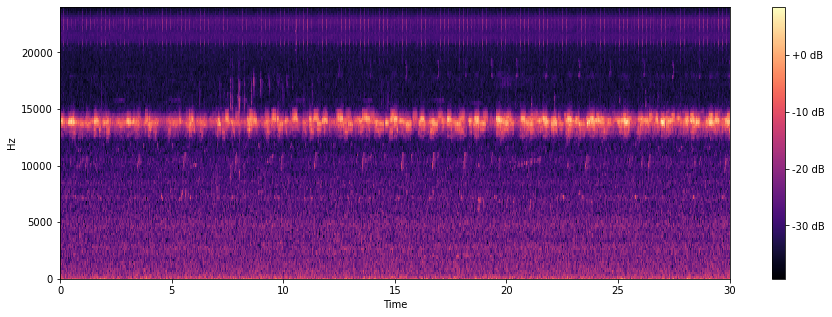

In [137]:
fig, ax = plt.subplots(figsize=(15, 5))
img = librosa.display.specshow(
    melspec, 
    sr=params.sr,
    x_axis='time', 
    y_axis='linear', 
    ax=ax)
fig.colorbar(img, ax=ax, format="%+2.f dB")
plt.show()

In [138]:
melspec.shape

(128, 2813)

In [139]:
melspec = melspec - np.min(melspec)
melspec = melspec / np.max(melspec)
melspec

array([[0.46033093, 0.47342625, 0.49706426, ..., 0.60881627, 0.6884991 ,
        0.6438922 ],
       [0.60932004, 0.6143687 , 0.53495675, ..., 0.53168017, 0.5631102 ,
        0.5385031 ],
       [0.57534814, 0.5830593 , 0.5322782 , ..., 0.56797373, 0.45954534,
        0.5281677 ],
       ...,
       [0.15049435, 0.11545823, 0.09962142, ..., 0.10734369, 0.11554088,
        0.13491024],
       [0.14096102, 0.10828955, 0.08532353, ..., 0.09748862, 0.10825428,
        0.11702343],
       [0.10953055, 0.0815257 , 0.07156514, ..., 0.08498293, 0.08853937,
        0.09282335]], dtype=float32)

In [140]:
np.save("melspec.npy", melspec)

In [141]:
%%timeit 
spec = np.load("melspec.npy")

728 µs ± 15.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [142]:
%%timeit 
y = load_audio(df_train["recording_id"][0], params.sr, TRAIN_AUDIO_ROOT)
melspec = compute_melspec(y, params)

220 ms ± 2.46 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Train

In [143]:
def load_and_save_train(record):
    # load data
    y = load_audio(record, params.sr, TRAIN_AUDIO_ROOT)

    # convert to mel
    melspec = compute_melspec(y, params)

    # normalize
    melspec = melspec - np.min(melspec)
    melspec = melspec / np.max(melspec)

    np.save(os.path.join(OUT_TRAIN, record + ".npy"), melspec)

In [144]:
_ = joblib.Parallel(n_jobs=8)(
    joblib.delayed(load_and_save_train)(record) for record in tqdm(df_train['recording_id'].values)
)

## Test

In [145]:
def load_and_save_test(record):
    # load data
    y = load_audio(record, params.sr, TEST_AUDIO_ROOT)

    # convert to melspec
    melspec = compute_melspec(y, params)

    # normalize
    melspec = melspec - np.min(melspec)
    melspec = melspec / np.max(melspec)

    np.save(os.path.join(OUT_TEST, record + ".npy"), melspec)

In [146]:
_ = joblib.Parallel(n_jobs=8)(
    joblib.delayed(load_and_save_test)(record) for record in tqdm(df_test['recording_id'].values)
)

In [ ]:
# shutil.make_archive(OUT_TEST, 'zip', OUT_TEST)
# shutil.rmtree(OUT_TEST)